# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')
# client = Client(n_workers=8, threads_per_worker=1, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:45919 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 192.00 GB


In [ ]:
client.close()

In [3]:
path_snow_CCI = 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0'

path_out = 'ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0'

In [ ]:
#https://dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2019/11/20191105-ESACCI-L3C_SNOW-SWE-SSMIS-DMSP-fv2.0.nc

In [6]:
# for i in range(1979, 2021):
#     print(i)
#     !mkdir {path_out}'/daily/'{str(i)}

1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


# Check data

In [7]:
ds = xr.open_dataset(path_snow_CCI+'/2019/11/20191105-ESACCI-L3C_SNOW-SWE-SSMIS-DMSP-fv2.0.nc')
ds

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600, nv: 2, time: 1)
Coordinates:
  * lat          (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon          (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.7 179.8 179.9
  * time         (time) datetime64[ns] 2019-11-05
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (lat, nv) float64 ...
    lon_bnds     (lon, nv) float64 ...
    swe          (time, lat, lon) float64 ...
    swe_std      (time, lat, lon) float64 ...
    spatial_ref  int32 ...
Attributes:
    institution:                FMI
    source:                     SSMIS brightness temperature data from 19 & 3...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                8f930064-9816-4dc6-9902-b3f95eed55a8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The ESA CCI Snow SWE product provides daily i...
    keywords:                   SSMIS, snow water equivalent, DMSP
    id:                         20191105-ESACCI-L3C_SNOW-SWE-SSMIS-DMSP-fv2.0.nc
    naming_authority:           fi.fmi
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              grid
    comment:                    The following auxiliary datasets are used for...
    date_created:               20211129T133020Z
    creator_name:               Finnish Meteorological Institute
    creator_url:                www.fmi.fi
    creator_email:              kari.luojus@fmi.fi (Scientific and Production...
    project:                    Climate Change Initiative European Space Agency
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lat_resolution:  0.1
    geospatial_lon_resolution:  0.1
    geospatial_lat_units:       degrees north
    geospatial_lon_units:       degrees east
    time_coverage_start:        20191105T000000Z
    time_coverage_end:          20191105T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v75
    license:                    ESA CCI Data Policy: free and open access; ac...
    platform:                   DMSP F17
    sensor:                     SSMI/S
    spatial_resolution:         0.10 degree
    key_variables:              swe
    doi:                        10.5285/4647cc9ad3c044439d6c643208d3c494
    history:                    20220207T140902Z: ESA snow_cci SWE processing...
    title:                      ESA CCI snow SWE product level L3C daily, Dyn...

In [9]:
ds.swe[0]

<xarray.DataArray 'swe' (lat: 1800, lon: 3600)>
[6480000 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.7 179.8 179.9
    time     datetime64[ns] 2019-11-05
Attributes:
    long_name:            Snow Water Equivalent
    grid_mapping:         spatial_ref
    units:                mm
    valid_range:          [  1 500]
    flag_values:          [-30 -20 -10  -1   0]
    flag_meanings:        Glacier Mountain Water no_data no_snow
    ancillary_variables:  swe_std
    actual_range:         [  1 114]

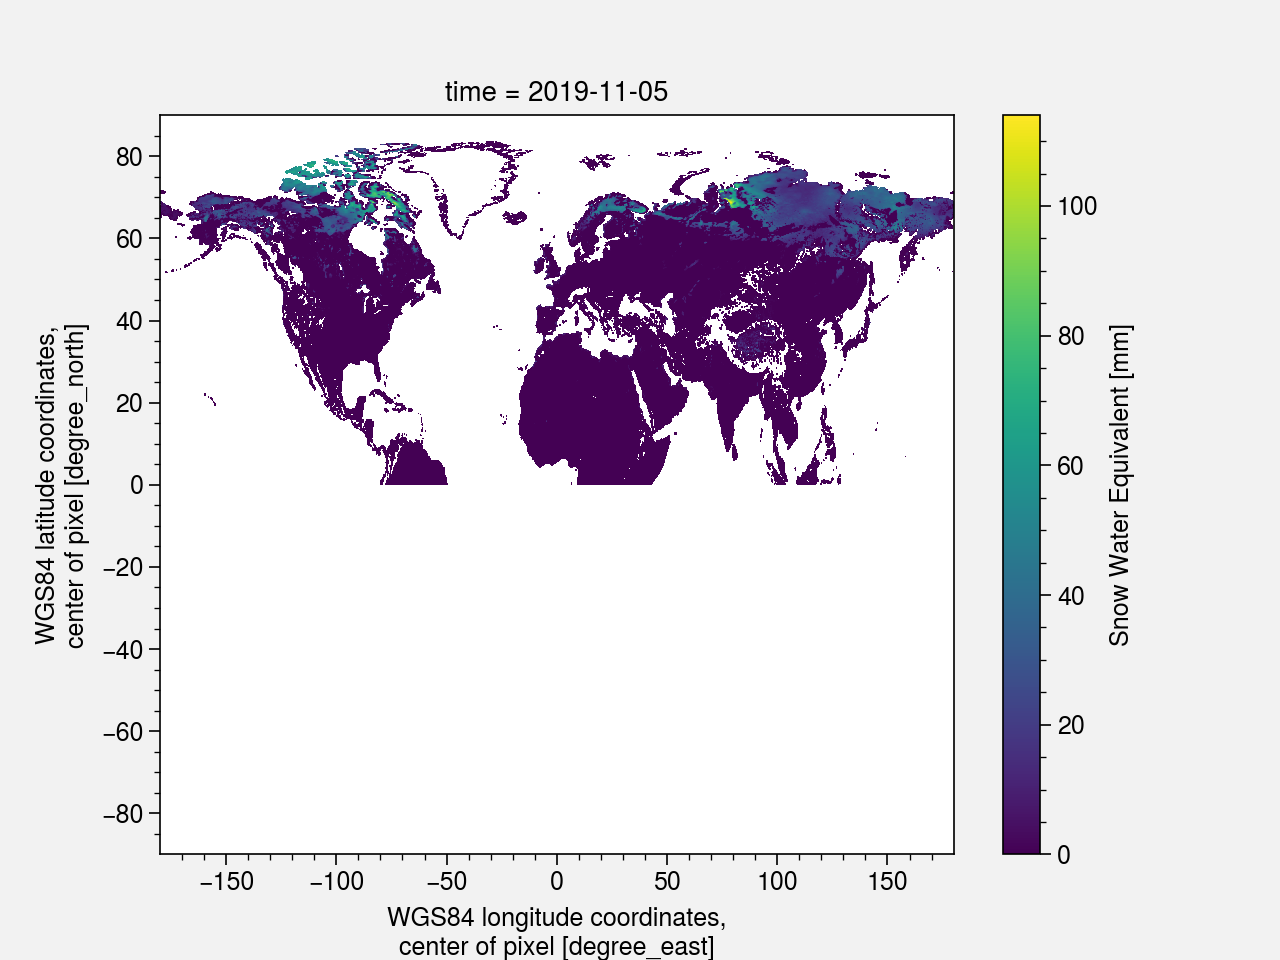

In [11]:
ds.swe[0].where(ds.swe[0] >= 0).plot()

SWE MERGED Dimensions:
- lat: 1800
- lon: 3600

On GRICAD 32 cores (6 Go)

In [14]:
print(32/4); print(1800/4); print(3600/8)

8.0
450.0
450.0


## Define functions

In [4]:
import xarray as xr
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Get previous month for interpolation
def get_prev_month_year(month, year):
    '''
    Returns the previous month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '12')
            year_prev (string): string (e.g., '1999')
    '''
    if month == '01':
        year_prev = str(int(year) - 1)
        month_prev = '12'
    else:
        year_prev = year
        month_prev = str(int(month) - 1).zfill(2)
        
    return month_prev, year_prev

# Get next month for interpolation
def get_next_month_year(month, year):
    '''
    Returns the next month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '02')
            year_prev (string): string (e.g., '2000')
    '''
    if month == '12':
        year_next = str(int(year) + 1)
        month_next = '01'
    else:
        year_next = year
        month_next = str(int(month) + 1).zfill(2)
        
    return month_next, year_next

# Round latitudes and longitudes to avoid errors with concatenation
def round_latlon(ds, latlon_round):
    '''
    Returns Dataset/DataArray with rounded latitudes and longitudes.

        Parameters:
            ds (Dataset/DataArray): xarray Dataset/Dataarray with coords lat/lon
            latlon_round (int): number of decimals

        Returns:
            xarray Dataset/DataArray
    '''
    return ds.assign_coords(lat=ds.lat.round(latlon_round), lon=ds.lon.round(latlon_round))

# Reindex time to get all days for interpolation
def reindex_time(ds, year, month):
    '''
    Returns Dataset/DataArray with all days in the corresponding month. Missing days will be filled with NaNs.

        Parameters:
            ds (Dataset/DataArray): monthly xarray Dataset/DataArray at daily time frequency
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')

        Returns:
            xarray Dataset/DataArray
    '''
    begin_date = pd.to_datetime(year+'-'+month+'-01')
    end_date = begin_date + MonthEnd(1) # Get the last day of the month
    return ds.reindex(time=pd.date_range(begin_date, end_date, freq='D'))

# Reindex time to get all days for interpolation
def open_files(path, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var):
    '''
    Open all daily files for a given month in parallel.
    Format is e.g., path+'/1994/01/19940101'+common_file_string
        
        Need to have Dask client defined before, e.g.:
            from dask.distributed import Client
            client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
            common_file_string (string): e.g., '-ESACCI-L3C_SNOW-swe-AVHRR_MERGED-fv2.0.nc'
            chunk_lat (int): chunk over the latitude dimension
            chunk_lon (int): chunk over the longitude dimension
            latlon_round (int): number of decimals
            var (string): variable to open (e.g., 'swe')

        Returns:
            da (DataArray): xarray DataArray
            attrs (dict): attributes from the original dataset
    '''
    ds = xr.open_mfdataset(path+'/'+year+'/'+month+'/*'+common_file_string, 
                           parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
    da = ds[var]
    da = round_latlon(da, latlon_round) # round coordinates to avoid errors with concatenation
    da = reindex_time(da, year, month) # to fill missing days with NaNs
    print('Read files '+path+'/'+year+'/'+month+'/*'+common_file_string)
            
    return da, ds.attrs

# Print no file to open
def print_no_file(path, year, month):
    '''
    Print the folder where there is no file.

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
    '''
    print('No file to open in: '+path+'/'+year+'/'+month)

# Select last delta_interp days for previous period
def select_last_days(da_prev, year_prev, month_prev, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_prev (DataArray): monthly xarray DataArray at daily time frequency
            year_prev (string): string (e.g., '2000')
            month_prev (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    end_date = pd.to_datetime(year_prev+'-'+month_prev) + MonthEnd(1) # Get the last day of the month
    begin_date = end_date - pd.DateOffset(days = delta_interp) # Get previous delta_interp days (max window for interpolation)
    return da_prev.sel(time=slice(begin_date, end_date))

# Select next delta_interp days for next period
def select_first_days(da_next, year_next, month_next, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_next (DataArray): monthly xarray DataArray at daily time frequency
            year_next (string): string (e.g., '2000')
            month_next (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    return da_next.sel(time=slice(year_next+'-'+month_next+'-01', year_next+'-'+month_next+'-'+str(delta_interp).zfill(2)))
     
# Concatenate DataArrays over time
def concat_files(da1, da2, concat_string):
    '''
    Concatenate DataArrays and remove chunks over the time dimension.

        Parameters:
            da1, da2 (DataArray): monthly xarray DataArray at daily time frequency
            concat_string (string): description of concatenation (e.g., '[prev, current]')

        Returns:
            xarray DataArray
    '''
    concat = xr.concat([da1, da2], dim='time').chunk({'time': -1})
    print(' => Concatenate files '+concat_string)
    
    return concat  


## Run interpolation

In [ ]:
#https://dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2019/11/20191105-ESACCI-L3C_SNOW-SWE-SSMIS-DMSP-fv2.0.nc

In [5]:
%%time

import time

chunk_lat = 450
chunk_lon = 450
delta_interp = 10 # maximum gap number of days for interpolation
latlon_round = 2 # precision for lat/lon
common_file_string = '.nc'
var = 'swe'

# for year in [str(y) for y in range(1979, 2021)]: 
# for year in [str(y) for y in range(1979, 1980)]:
# for year in [str(y) for y in range(1980, 2000)]:
for year in [str(y) for y in range(2000, 2021)]:
    for month in [str(m).zfill(2) for m in range(1, 13)]:
#     for month in [str(m).zfill(2) for m in range(6, 9)]:
        start_time = time.time() # Check time per loop
        
        # Get previous and next months for interpolation         
        month_prev, year_prev = get_prev_month_year(month, year)
        month_next, year_next = get_next_month_year(month, year)
        print('\n### '+year+'-'+month+' (prev: '+year_prev+'-'+month_prev+' / next: '+year_next+'-'+month_next+')')
        
        ##################
        ### Open files ###
        ##################
        # Test if there are files (ex: 1994-11 to 1995-01 no files for AVHRR)
        try:
            da, attrs = open_files(path_snow_CCI, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
        except OSError:
            print_no_file(path_snow_CCI, year, month)
            continue # If there is no file, go to next iteration
        
        # Prev
        try:
            da_prev, _ = open_files(path_snow_CCI, year_prev, month_prev, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
            da_prev = select_last_days(da_prev, year_prev, month_prev, delta_interp)
            concat = concat_files(da_prev, da, '[prev, current]')
            
            # Next
            try:
                da_next, _ = open_files(path_snow_CCI, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(concat, da_next, '[concat, next]')
            except OSError:
                print_no_file(path_snow_CCI, year_next, month_next)

        except OSError:
            print_no_file(path_snow_CCI, year_prev, month_prev)
        
            # Next
            try:
                da_next, _ = open_files(path_snow_CCI, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(da, da_next, '[current, next]')
            except OSError:
                print_no_file(path_snow_CCI, year_next, month_next)
                concat = da.chunk({'time': -1})

        ###############################################
        ### Get SWE values and, water and ice masks ###
        ###############################################
        swe = concat.where(concat >= 0)
        
        ###############################
        ### Linear temporal gapfill ###
        ###############################
        swe_interp = swe.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=delta_interp))
        print(' => Doing interpolation...')

        # Deal with attributes
        swe_interp.name = var+'_interp'
        del swe_interp.attrs['valid_range']
        del swe_interp.attrs['flag_values']
        del swe_interp.attrs['flag_meanings']
        swe_interp.attrs['ancillary_variables'] = 'coverage, coverage_interp'
        swe_interp.attrs['method'] = var+".interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))"

        # Compute time coverage
        coverage = swe.sel(time=year+'-'+month).count('time')
        coverage.name = 'coverage'
        coverage.attrs['long_name'] = 'Time Coverage'
        coverage.attrs['units'] = 'number of days'
        coverage.attrs['ancillary_variables'] = var

        coverage_interp = swe_interp.sel(time=year+'-'+month).count('time')
        coverage_interp.name = 'coverage_interp'
        coverage_interp.attrs['long_name'] = 'Time Coverage'
        coverage_interp.attrs['units'] = 'number of days'
        coverage_interp.attrs['ancillary_variables'] = var+'_interp'

        # Combine in a new dataset
        ds_interp = swe_interp.sel(time=year+'-'+month).to_dataset()
        ds_interp['coverage'] = coverage
        ds_interp['coverage_interp'] = coverage_interp
        ds_interp.attrs = {**{'processed': 'A linear interpolation on the time dimension is performed in this dataset. ' \
            'A maximum window of 10 days is imposed, if the gap is more than 10 days, the missing values are kept. ' \
            'Before interpolation the time dimension is reindexed in order to cover all days of the month, and fill missing days with NaNs.' \
            'Also the latitudes and longitudes are rounded to 3 digits after de decimal to avoid concatenation errors.' \
            'The temporal coverage of the data before and after interpolation is stored in the variables "coverage" and "coverage_interp". ' \
            'The permanent snow and ice, and water masks are also kept for later processing if needed. The original dataset is described below. ' \
            'Preprocess performed by Mickaël Lalande (https://mickaellalande.github.io/) on June 3, 2022. ' \
            'The same compression level is kept compared to the original dataset (zlib=True, complevel=4).'}, **attrs}

        # Compression
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds_interp.data_vars}
        ds_interp.to_netcdf(path_out+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc', encoding=encoding)
        print('Interpolated file saved to '+path_out+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc')
        print("--- %s seconds ---" % (time.time() - start_time))


### 2000-01 (prev: 1999-12 / next: 2000-02)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2000/01/*.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/1999/12/*.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2000/02/*.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Interpolated file saved to ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2000/200001-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 118.53972172737122 seconds ---

### 2000-02 (prev: 2000-01 / next: 2000-03)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2000/02/*.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2000/01/*.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/swe/MERGED/v2.0/2000/03/*.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Inte

## Check

In [9]:
swe.sel(lat=50, lon=110, method='nearest').values

array([ 0.,  0., nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan,  0., nan,  0.,  0.,
       nan, nan, nan, nan,  0., nan, nan, nan,  0., nan, nan, nan, nan,
       nan, nan, nan])

In [10]:
swe_interp.sel(lat=50, lon=110, method='nearest').values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan,
       nan, nan, nan])

In [11]:
ds_interp.swe_interp.sel(lat=50, lon=110, method='nearest').values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan,
       nan, nan, nan, nan, nan])

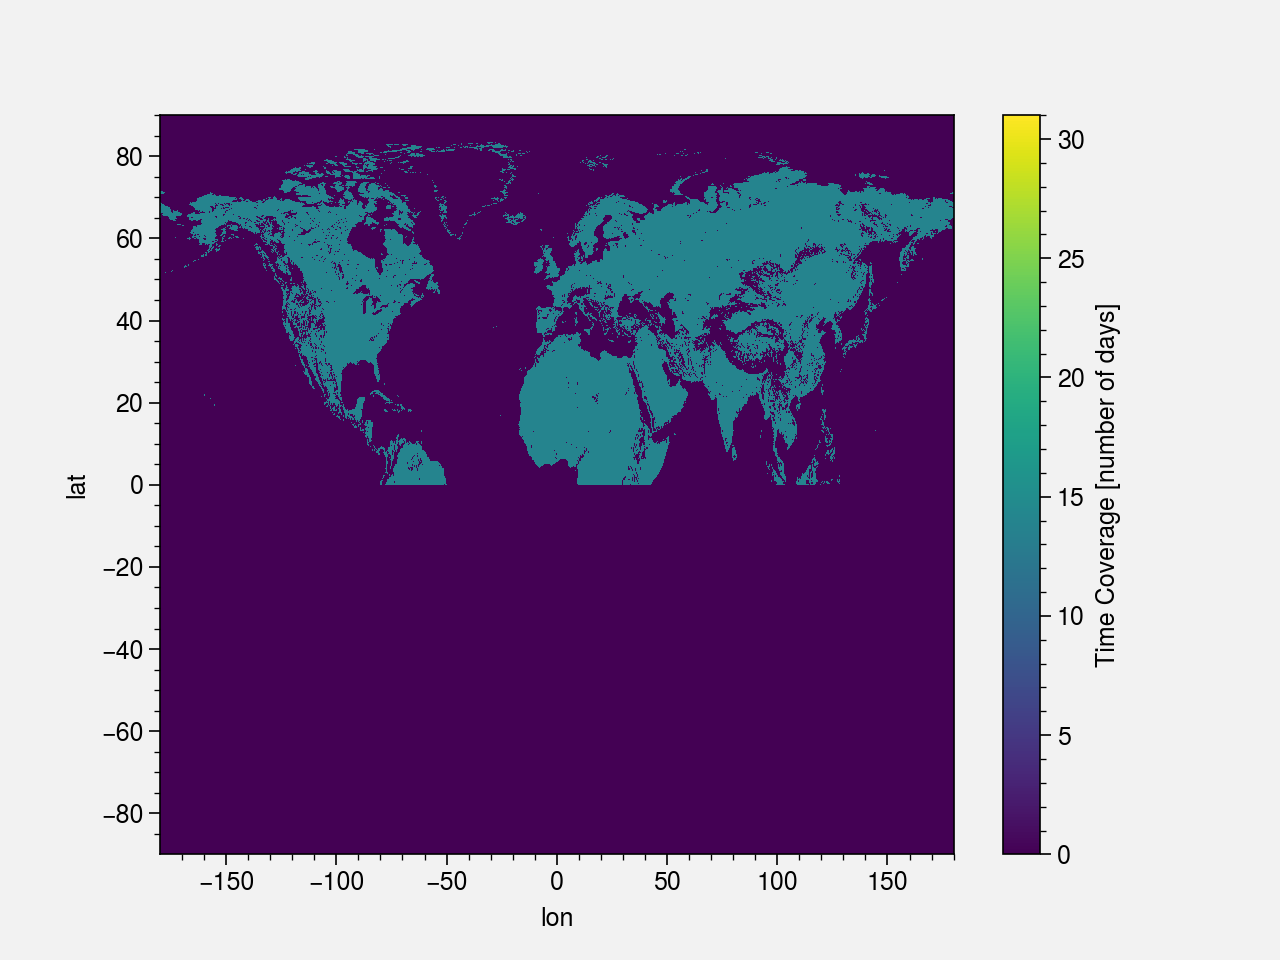

In [6]:
ds_interp.coverage.plot(vmax=31)

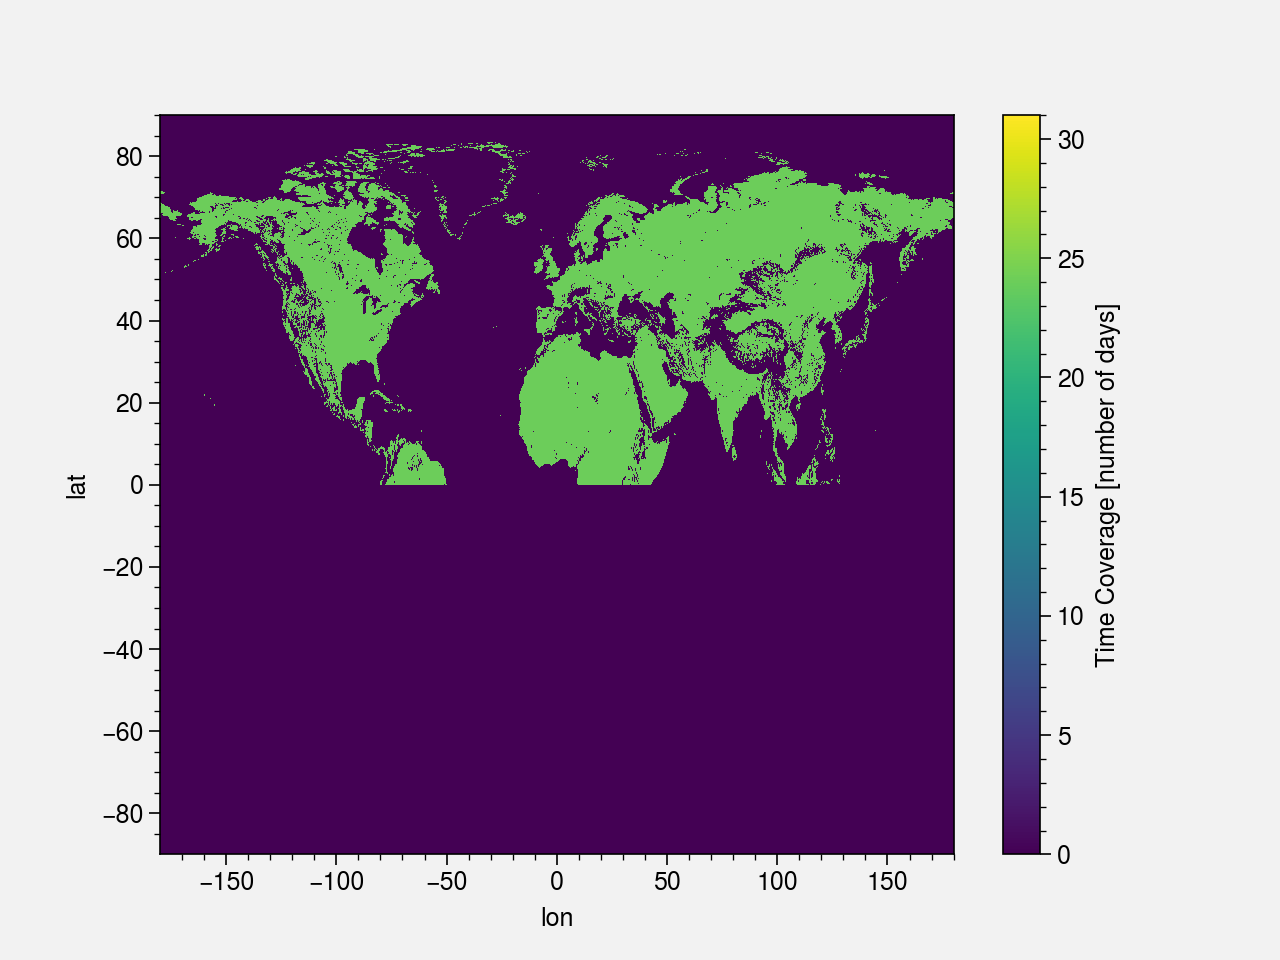

In [7]:
ds_interp.coverage_interp.plot(vmax=31)

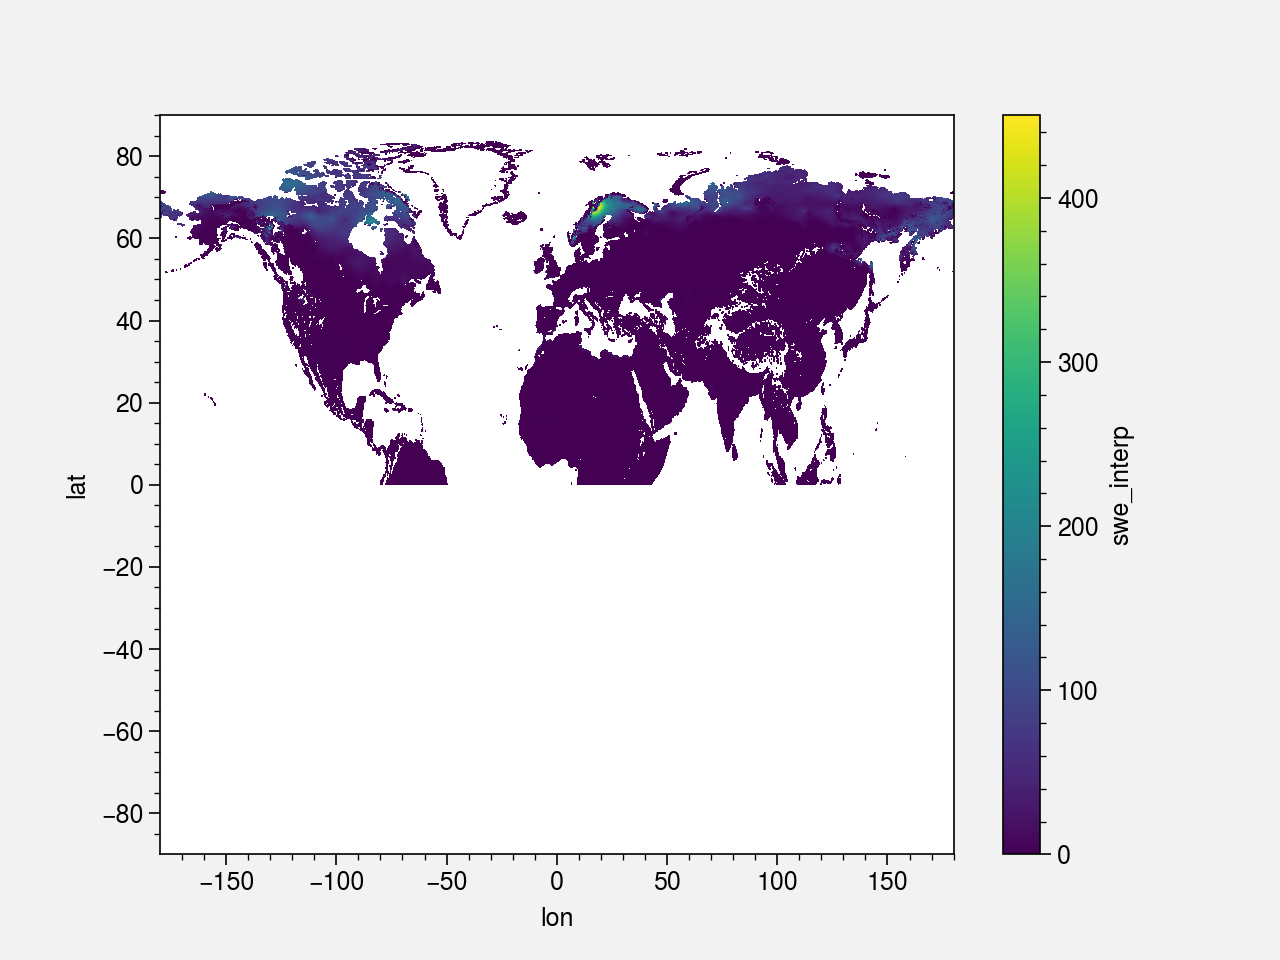

In [8]:
ds_interp.swe_interp.mean('time').plot()

# Make monthly mean

In [13]:
root_path_in = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily'
root_path_out = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly'

SWE MERGED Dimensions:
- lat: 1800
- lon: 3600

On GRICAD 32 cores (6 Go)

In [14]:
print(32/4); print(1800/4); print(3600/8)

8.0
450.0
450.0


In [14]:
%%time

import time

chunk_lat = 450 
chunk_lon = 450 

for year in [str(y) for y in range(1979, 2021)]:
# for year in [str(y) for y in range(1988, 2019)]:
    start_time = time.time() # Check time per loop
    
    print('\n### '+year)
    
    ds = xr.open_mfdataset(root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc', parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
#     ds = xr.open_mfdataset(root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-swe-AVHRR_MERGED-fv2.0_interp.nc', parallel=True)
    print('Read files '+root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc')
    
#     ds_month = ds.chunk({'time': -1}).resample(time='1M').mean() # too heavy
    ds_month = ds.resample(time='1M').mean()
    print(' => Perform monthly resample average...')
    
    ds_month.attrs = ds.attrs
    
     # Compression
    comp = dict(zlib=True, complevel=4)
    encoding = {var: comp for var in ds_month.data_vars}
    ds_month.to_netcdf(root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc', encoding=encoding)
    print('Monthly file saved to '+root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc')
    print("--- %s seconds ---" % (time.time() - start_time))


### 1979
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1979/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1979-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 102.39372301101685 seconds ---

### 1980
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1980/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1980-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 106.34158277511597 seconds ---

### 1981
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1981/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1981-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 116.2567069530487 seconds ---

### 1982
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1982/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1982-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 119.58916473388672 seconds ---

### 1983
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1983/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1983-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 118.65548706054688 seconds ---

### 1984
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1984/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1984-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.41467332839966 seconds ---

### 1985
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1985/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1985-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 118.73807978630066 seconds ---

### 1986
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1986/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1986-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.76381778717041 seconds ---

### 1987
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1987/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1987-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.8657295703888 seconds ---

### 1988
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1988/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1988-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 108.13485813140869 seconds ---

### 1989
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1989/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1989-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 118.04134678840637 seconds ---

### 1990
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1990/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1990-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.78186511993408 seconds ---

### 1991
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1991/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1991-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.16370105743408 seconds ---

### 1992
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1992/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1992-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.3254246711731 seconds ---

### 1993
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1993/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1993-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 118.22346639633179 seconds ---

### 1994
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1994/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1994-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.96478581428528 seconds ---

### 1995
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1995/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1995-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.58019638061523 seconds ---

### 1996
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1996/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1996-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.55299043655396 seconds ---

### 1997
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1997/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1997-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.65766048431396 seconds ---

### 1998
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1998/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1998-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.12163734436035 seconds ---

### 1999
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/1999/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/1999-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 116.5344500541687 seconds ---

### 2000
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2000/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2000-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.40592527389526 seconds ---

### 2001
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2001/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2001-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.51243448257446 seconds ---

### 2002
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2002/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2002-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.31342053413391 seconds ---

### 2003
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2003/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2003-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.19604969024658 seconds ---

### 2004
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2004/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2004-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.4886827468872 seconds ---

### 2005
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2005/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2005-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.24346852302551 seconds ---

### 2006
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2006/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2006-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 107.0785562992096 seconds ---

### 2007
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2007/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2007-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.38732194900513 seconds ---

### 2008
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2008/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2008-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 106.5374448299408 seconds ---

### 2009
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2009/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2009-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.59019994735718 seconds ---

### 2010
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2010/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2010-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 116.68541955947876 seconds ---

### 2011
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2011/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2011-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 101.87139797210693 seconds ---

### 2012
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2012/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2012-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.15107750892639 seconds ---

### 2013
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2013/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2013-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 116.76541996002197 seconds ---

### 2014
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2014/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2014-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 104.73578953742981 seconds ---

### 2015


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2015/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2015-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.46492457389832 seconds ---

### 2016
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2016/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2016-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 105.84830260276794 seconds ---

### 2017


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2017/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2017-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 117.90991044044495 seconds ---

### 2018
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2018/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2018-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 106.15832209587097 seconds ---

### 2019
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2019/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2019-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 102.56238603591919 seconds ---

### 2020
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/daily/2020/*-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/swe/MERGED/v2.0/monthly/2020-monthly-ESACCI-L3C_SNOW-SWE-fv2.0_interp.nc
--- 68.53296446800232 seconds ---
CPU times: user 28min 18s, sys: 3min 46s, total: 32min 4s
Wall time: 1h 15min 4s


## Check

In [15]:
ds = xr.open_mfdataset(root_path_out+'/*.nc', parallel=True)
ds

,Array,Chunk
Bytes,25.76 GB,622.08 MB
Shape,"(497, 1800, 3600)","(12, 1800, 3600)"
Count,126 Tasks,42 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,25.76 GB,622.08 MB
Shape,"(497, 1800, 3600)","(12, 1800, 3600)"
Count,126 Tasks,42 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


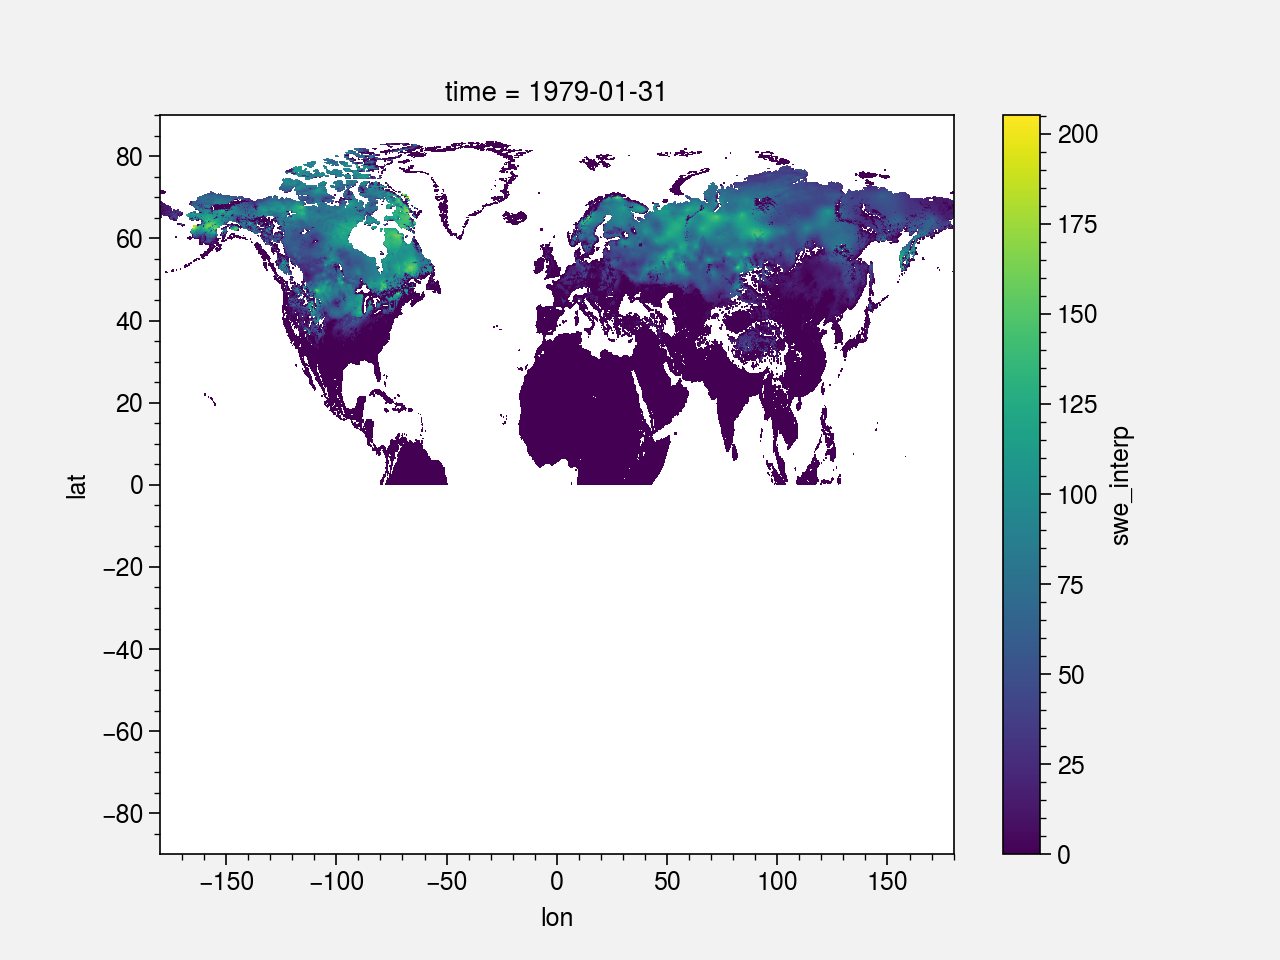

In [16]:
ds.swe_interp[0].plot()

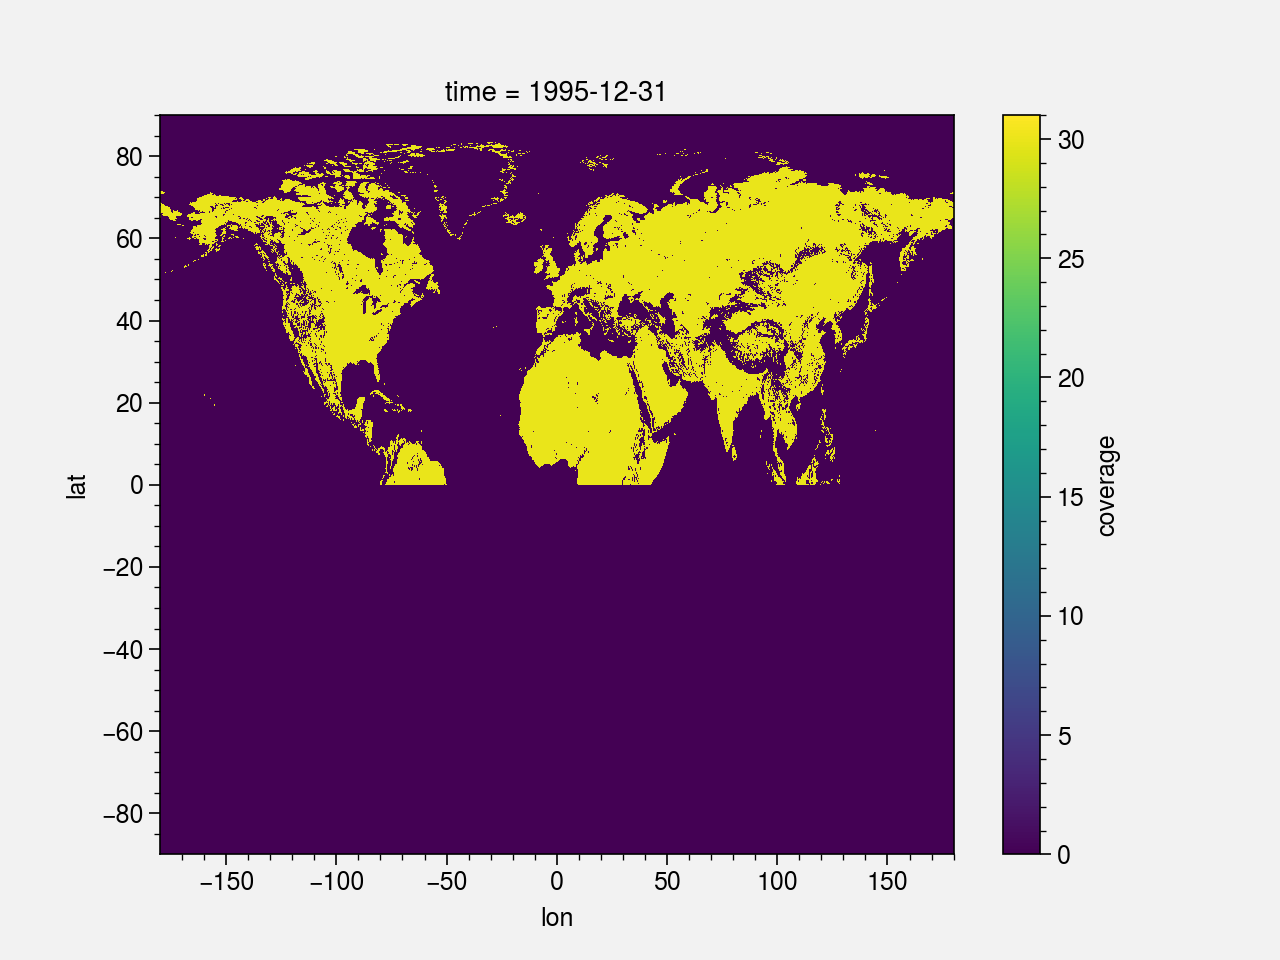

In [29]:
ds.coverage[203].plot(vmax=31)

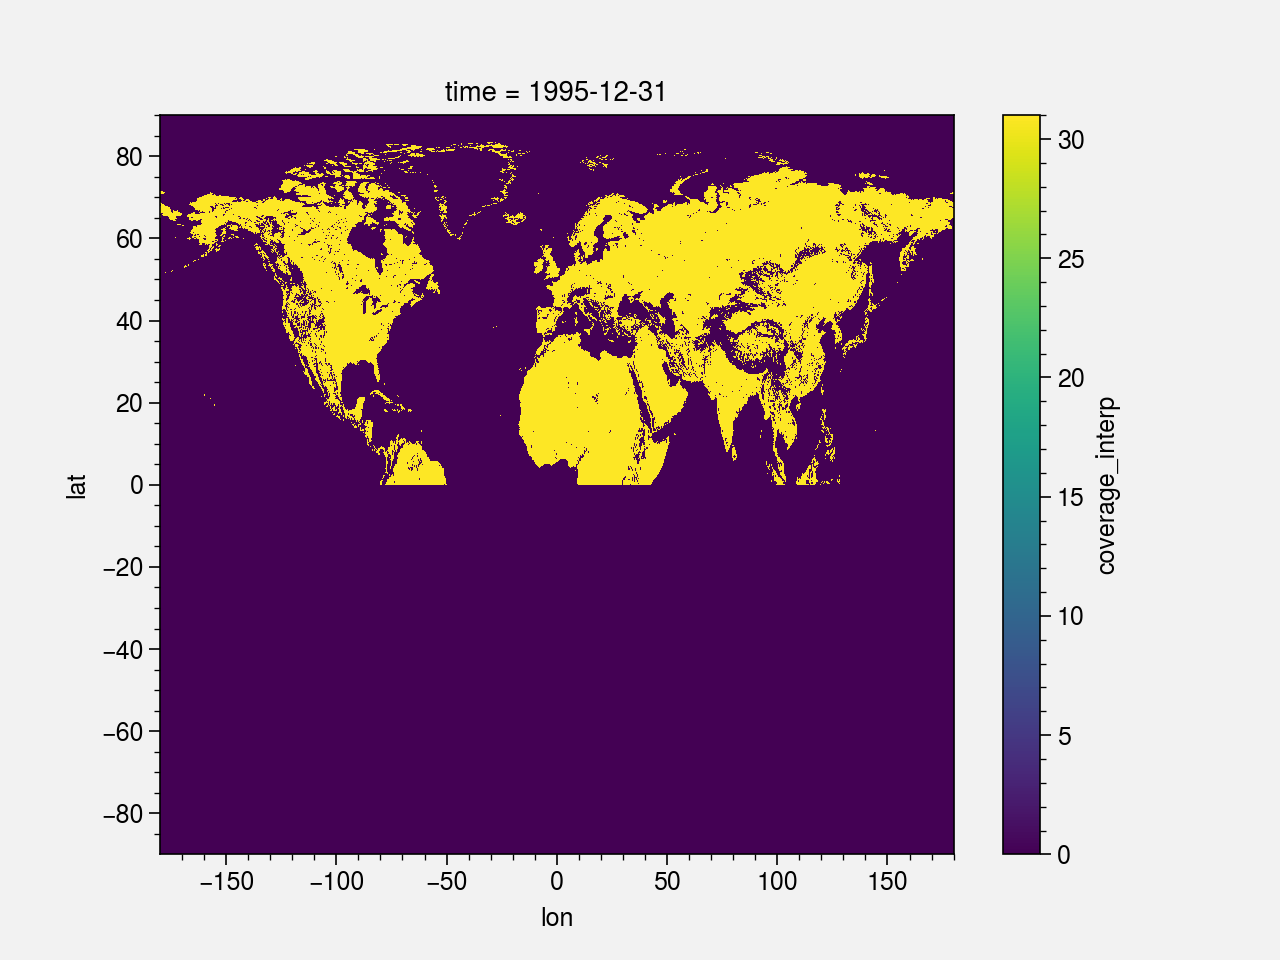

In [30]:
ds.coverage_interp[203].plot(vmax=31)

# Make spatial average

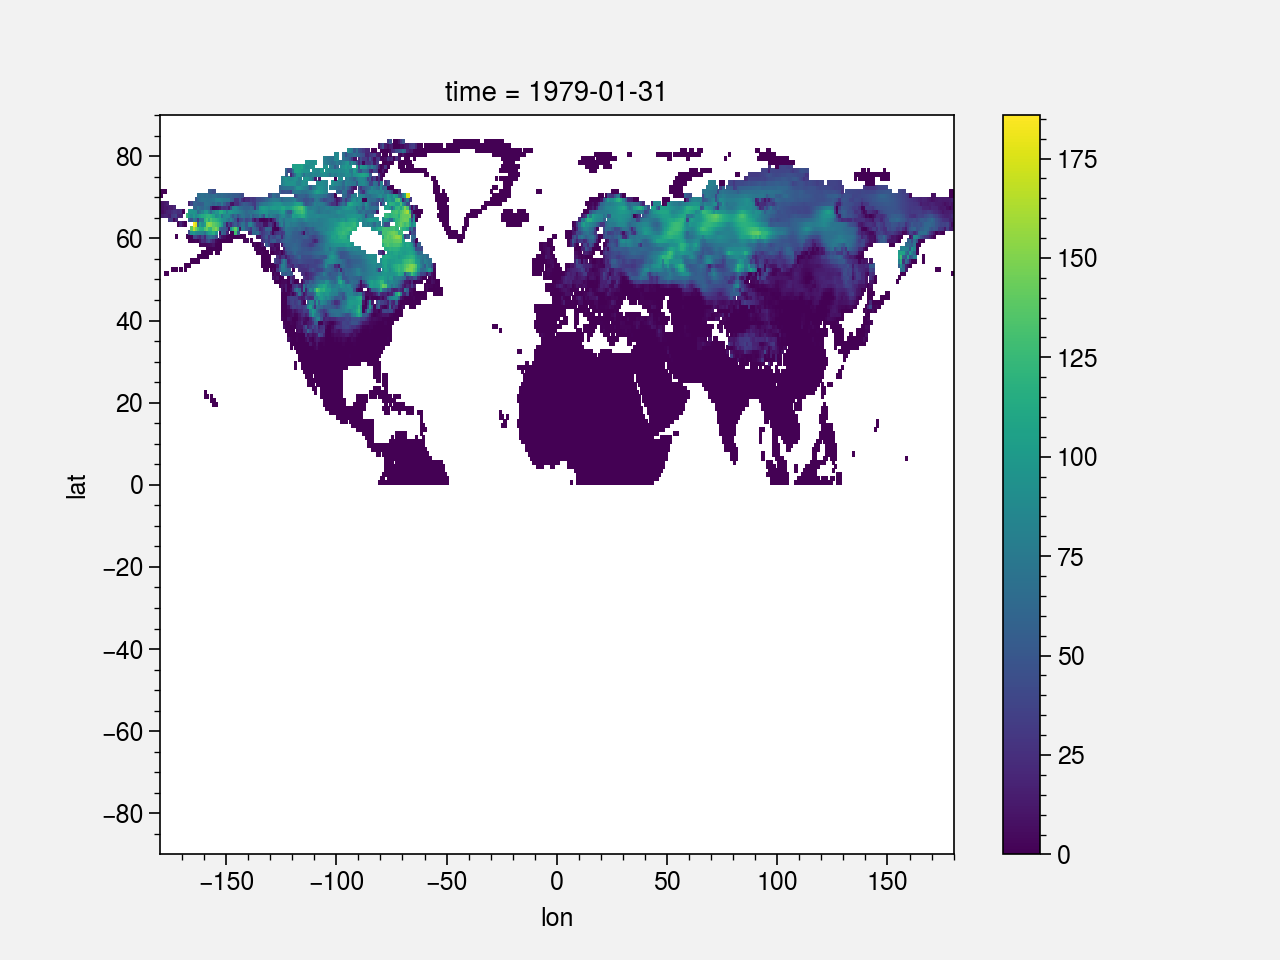

In [36]:
ds.swe_interp[0].coarsen(lat=10, lon=10).mean().plot()

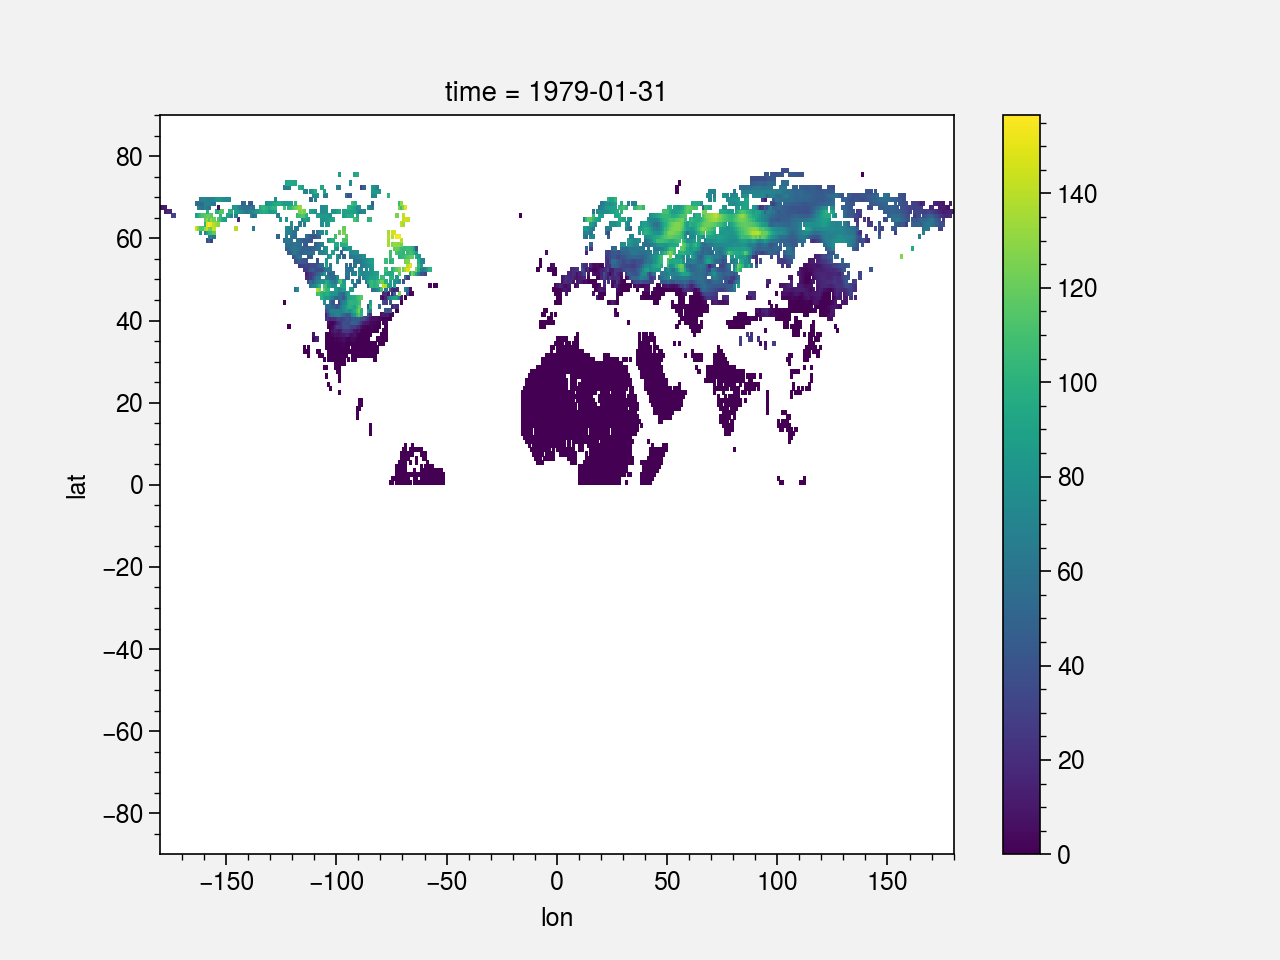

In [37]:
ds.swe_interp[0].coarsen(lat=10, lon=10).mean(skipna=False).plot()

Need to make a conservative regridding with mask mountains in target grid to make something coherent...